# Clustering

In [1]:
# Lets as usual start by loading some data,
# this time we will need both eigen-vectors and values

import numpy as np
from tqdm import tqdm


def load_eigs_npz(filename='results/results-L-2-W-0.1-seed-0.npz'):
    data = np.load(filename)
    eigvals = data[data.files[0]]
    eigvecs = data[data.files[1]]

    return eigvals, eigvecs.T

Files = []

Ls, num_seeds = [12], 42
ws = [0.3, 0.6, 0.8999999999999999, 1.2,  1.5, 1.8, 2.0999999999999996, 2.4, 2.6999999999999997, 2.9999999999999996, 3.3, 3.5999999999999996, 3.8999999999999995, 4.2, 4.5, 4.8, 5.1,5.3999999999999995, 5.699999999999999, 6.0]

vecs, vecs_flat, vals = [], [], []
for L in Ls:
    for w in tqdm(ws):
        files = []
        for seed in range(num_seeds):
            file = '/Users/antongolles/results1/results-L-{}-W-{}-seed-{}.npz'.format(L,w,seed)
            eigvals, eigvecs = load_eigs_npz(file)
            vecs.append(eigvecs)
            vecs_flat.append(eigvecs.flatten())
            vals.append(eigvals)

vecs, vecs_flat, vals = np.array(vecs), np.array(vecs_flat), np.array(vals)
np.shape(vecs), np.shape(vecs_flat), np.shape(vals)

100%|██████████| 20/20 [02:06<00:00,  6.31s/it]


((840, 924, 924), (840, 853776), (840, 924))

In [2]:
from sklearn.cluster import AffinityPropagation, Birch, SpectralClustering, MeanShift
from sklearn.cluster import AgglomerativeClustering, DBSCAN, OPTICS, KMeans

#Kmeans on both, optics on vecs, meanshift on vals

def run_clustering(X, which=['KMeans', 'optics', 'meanshift']):
    results = []
    if which == 'all':
        which=['KMeans', 'Affinity Propagation', 'Birch', 'Spectral Clustering', 
               'Agglomerative Clustering', 'DBSCAN', 'MeanShift', 'OPTICS']
    if 'KMeans' in which:
        kmeans = KMeans(2, verbose=1).fit(abs(np.array(X)))
        results.append(kmeans.labels_)
    if 'Affinity Propagation' in which:
        affinityPropagation = AffinityPropagation(random_state=5, damping=.99).fit(X)
        results.append(affinityPropagation.labels_)
    if 'Birch' in which:
        brc = Birch(n_clusters=2)
        brc.fit(X)
        birch_labels = brc.predict(X)
        results.append(birch_labels)
    if 'Spectral Clustering' in which:
        spectralClustering = SpectralClustering(n_clusters=2,
                                                assign_labels="discretize",
                                                random_state=0).fit(X)
        results.append(spectralClustering.labels_)
    if 'Agglomerative Clustering' in which:
        agglomerativeClustering = AgglomerativeClustering().fit(X)
        results.append(agglomerativeClustering.labels_)
    if 'DBSCAN' in which:
        db = DBSCAN(eps=3, min_samples=8,leaf_size=10).fit(X)
        results.append(db.labels_)
    if 'MeanShift' in which:
        meanShift = MeanShift(bandwidth=20).fit(X)
        results.append(meanShift.labels_)
    if 'OPTICS' in which:
        optics = OPTICS(min_samples=2).fit(X)
        results.append(optics.labels_)
        
    return np.array(results), which

In [3]:

results_vecs, which_vecs = run_clustering(vecs_flat, ['KMeans'])
results_vals, which_vals = run_clustering(vals, ['KMeans'])

Initialization complete
Iteration 0, inertia 1144783.4314896255
Iteration 1, inertia 678072.9918561771
Iteration 2, inertia 655446.1866214693
Iteration 3, inertia 650082.2760276446
Iteration 4, inertia 649272.8315792396
Iteration 5, inertia 649153.2753837939
Iteration 6, inertia 649095.0312889509
Iteration 7, inertia 649085.4002301348
Converged at iteration 7: center shift 1.5356467438172636e-31 within tolerance 9.5609543851773e-08
Initialization complete
Iteration 0, inertia 1169314.8571074835
Iteration 1, inertia 683573.4683372094
Iteration 2, inertia 683470.8343525005
Converged at iteration 2: center shift 1.7382446538575934e-30 within tolerance 9.5609543851773e-08
Initialization complete
Iteration 0, inertia 1221944.9418789307
Iteration 1, inertia 683399.7614340498
Converged at iteration 1: center shift 1.5694146627878723e-30 within tolerance 9.5609543851773e-08
Initialization complete
Iteration 0, inertia 1144117.392590464
Iteration 1, inertia 679607.0639767182
Iteration 2, inerti

In [48]:
results = np.vstack([results_vals, results_vecs])
results = results_vecs.copy()

In [49]:
results = results.reshape(20,42).T
np.shape(results)

(42, 20)

In [50]:
xticks = [round(w,2) for w in ws]
def func(a):
    if a % 0.6 <= 0.1:
        return ' '
    else:
        return a
xticks = [func(w) for w in xticks]


#yticks = [0]+[' ']*19+[20]+[' ']*19+[40]


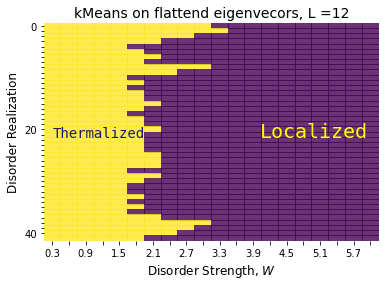

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(results, cbar=False,
                cmap='viridis_r',  
                xticklabels=xticks,
               yticklabels=yticks,
           alpha=.8)
    #plt.show()
plt.xlabel('Disorder Strength, $W$', fontsize=12)
plt.ylabel('Disorder Realization', fontsize=12)
plt.title('kMeans on flattend eigenvecors, L =12', fontsize=14)
plt.text(0.5, 22, 'Thermalized', fontsize=14,c='midnightblue',  family='monospace')
plt.text(12.9, 22, 'Localized', fontsize=20, c='yellow', family='monospace')
plt.savefig('figures/clustering_RAW.png', dpi=500, bbox_inches='tight')

In [76]:
# We have run for many seeds, so lets average the results
def get_means(results_for_many_seeds):
    print(np.shape(results_for_many_seeds))
    results = results_for_many_seeds
    means = []
    stds = []
    for index,i in enumerate(results):
        reformatted_result = i.reshape(len(ws), num_seeds)
        #print(np.shape(reformatted_result))
        mean = np.mean(reformatted_result, axis=1)
        std1 = np.std(reformatted_result, axis=1)
        #print(np.shape(mean))
        #print(mean)
        means.append(mean)
        stds.append(std1)
    return np.array(means), np.array(stds)
means, stds = get_means(results_vecs)
print(np.shape(means))

(1, 840)
(1, 20)


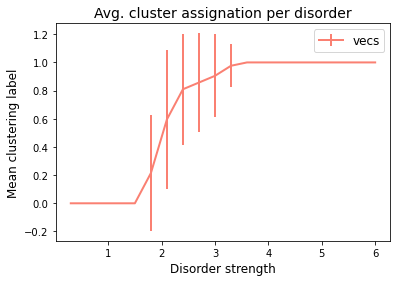

In [86]:
import matplotlib.pyplot as plt
plt.figure()
colors = 'salmon, yellowgreen, orange, black, red, lightblue'.split(', ')

which = ['vals', 'vecs'][::-1]
for mean, std, label, color in zip(means, stds, which, colors):
    #plt.errorbar(ws,i/max(i), label=label)
    plt.errorbar(ws, mean, std, xerr=None, 
                 label=label, 
                 c=color, lw=2)
    
plt.legend(fontsize=12)

plt.title('Avg. cluster assignation per disorder', fontsize=14)
plt.xlabel('Disorder strength', fontsize=12)
plt.ylabel('Mean clustering label', fontsize=12)
#plt.ylim([-0.1,1.1])
plt.savefig('figures/clustering_means.png', dpi=500, bbox_inches='tight')

In [81]:
for w, val in zip(ws,mean):
    print(val,w)# 1.5 - 3.6
    # 2.55 +- 1.05 

0.0 0.3
0.0 0.6
0.0 0.8999999999999999
0.0 1.2
0.0 1.5
0.21428571428571427 1.8
0.5952380952380952 2.0999999999999996
0.8095238095238095 2.4
0.8571428571428571 2.6999999999999997
0.9047619047619048 2.9999999999999996
0.9761904761904762 3.3
1.0 3.5999999999999996
1.0 3.8999999999999995
1.0 4.2
1.0 4.5
1.0 4.8
1.0 5.1
1.0 5.3999999999999995
1.0 5.699999999999999
1.0 6.0


In [5]:
sum([i<0 for i in L])

1